![CrowdAI-Logo](https://github.com/crowdAI/crowdai/raw/master/app/assets/images/misc/crowdai-logo-smile.svg?sanitize=true)

# Mapping Challenge (Dataset Utils)

**Author** : [Sharada Mohanty](mailto:sharada.mohanty@epfl.ch)

The dataset for the [crowdAI Mapping Challenge](https://www.crowdai.org/challenges/mapping-challenge) is available at [https://www.crowdai.org/challenges/mapping-challenge/dataset_files](https://www.crowdai.org/challenges/mapping-challenge/dataset_files)

This dataset contains :   
* `train.tar.gz` : This is the Training Set of **280741** tiles (as `300x300` pixel RGB images) of satellite imagery, along with their corresponding annotations in [MS-COCO format](http://cocodataset.org/#home)

* `val.tar.gz`: This is the suggested Validation Set of **60317** tiles (as `300x300` pixel RGB images) of satellite imagery, along with their corresponding annotations in [MS-COCO format](http://cocodataset.org/#home)

* `test_images.tar.gz` : This is the Test Set for Round-1, where you are provided with **60697** files (as 300x300 pixel RGB images) and your are required to submit annotations for all these files.     


To get started, we would advise you to download all the files, and untar them inside the `data/` folder of this repository, so that you have a directory structure like this : 

```bash
|-- data/
|   |-- test_images/ (has all images for prediction)
|   |-- train/
|   |   |-- images (has all the images for training)
|   |   |__ annotation.json : Annotation of the data in MS COCO format
|   |   |__ annotation-small.json : Smaller version of the previous dataset
|   |-- val/
|   |   |-- images (has all the images for training)
|   |   |__ annotation.json : Annotation of the data in MS COCO format
|   |   |__ annotation-small.json : Smaller version of the previous dataset
```

We are also assuming that you have already installed all the requirements for this notebook, or you can still install them by :

In [ ]:
!pip install -r requirements.txt

## Import dependencies

**Note**: If you are using `Python3.*`, then there are chances that `pycocotools` will not work for you. In that case, we would suggest installing it from this fork : 
```
pip install git+https://github.com/crowdai/coco.git#subdirectory=PythonAPI
```

In [18]:
%matplotlib inline
from pycocotools.coco import COCO
from pycocotools import mask as cocomask
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
import os
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

## Configuration Variables

In [3]:
data_directory = "data/"
annotation_file_template = "{}/{}/annotation{}.json"

TRAIN_IMAGES_DIRECTORY = "data/train/images"
TRAIN_ANNOTATIONS_PATH = "data/train/annotation.json"
TRAIN_ANNOTATIONS_SMALL_PATH = "data/train/annotation-small.json"

VAL_IMAGES_DIRECTORY = "data/val/images"
VAL_ANNOTATIONS_PATH = "data/val/annotation.json"
VAL_ANNOTATIONS_SMALL_PATH = "data/val/annotation-small.json"

## Parsing the annotations 

This dataset releases the annotations in the [MS COCO format](http://cocodataset.org/#format). Please read up more about it at : [http://cocodataset.org/#format](http://cocodataset.org/#format).

For this demonstration we are using, the `annotation-small.json` files for convenience, but all the examples will work for the larger `annotation.json` files.

In [4]:
coco = COCO(TRAIN_ANNOTATIONS_SMALL_PATH)

loading annotations into memory...
Done (t=0.71s)
creating index...
index created!



The dataset has labels for a single category : `Building` and the corresponding `category_id` is `100`. But for the sake of generalisability, it is better to use the `cocoapi` to collect the `category_ids` to ensure that in a later version of the dataset if we add more categories, your code will consistently work for the same.

In [5]:
category_ids = coco.loadCats(coco.getCatIds())
print(category_ids)

[{'id': 100, 'name': 'building', 'supercategory': 'building'}]


## Collecting and Visualizing Images

In [6]:
# This generates a list of all `image_ids` available in the dataset
image_ids = coco.getImgIds(catIds=coco.getCatIds())

In [7]:
# For this demonstration, we will randomly choose an image_id
random_image_id = random.choice(image_ids)

In [8]:
# Now that we have an image_id, we can load its corresponding object by doing :
img = coco.loadImgs(random_image_id)[0]

A single image object, doesnot really load the actual image, but just the relevant meta data we have about the image. In this case, the contents of the `img` variable will be something along the lines of : 
```bash
{
   "id":15998,
   "file_name":"000000015998.jpg",
   "width":300,
   "height":300
}
```

Now we can finally compute the actual path of the image, and load and render it by :

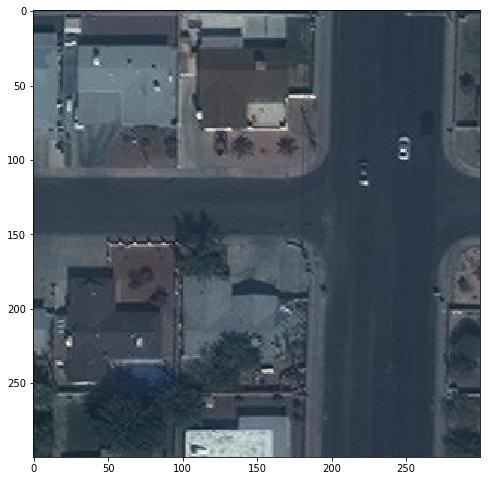

In [19]:
image_path = os.path.join(TRAIN_IMAGES_DIRECTORY, img["file_name"])
I = io.imread(image_path)
plt.imshow(I)

## Understanding Annotations

Given a **numeric** `image_id` for an image, then we can load the corresponding annotations for the image by doing : 

In [20]:
annotation_ids = coco.getAnnIds(imgIds=img['id'])
annotations = coco.loadAnns(annotation_ids)

The `coco.getAnnIds` will first return a `list` of all annotation objects which are associated with the said `image_id`, and then `coco.loadAnns` will return a list of the actual annotation objects.

A single annotation object has the following structure : 

```javascript
    {
       "id":409190,
       "image_id":48034,
       "segmentation":[
          [
             94,
             78,
             32,
             78,
             32,
             25,
             94,
             25,
             94,
             78
          ]
       ],
       "area":3286.0,
       "bbox":[
          32,
          32,
          62,
          62
       ],
       "category_id":100,
       "iscrowd":0
    }
```

Where the individual fields have the following meaning : 
* `id` : A **unique** id for the annotation.   
         But please note that, annotations across the train/val splits of the same dataset or different datasets can still be the same number.

* `image_id` : A **unique** id for the referenced image.
         But please note that, images across the train/val splits of the same dataset or different datasets can still have the same `image_id`.

* `segmentation` : This holds the actual annotation markers, and it can be in different formats : `poly`, `rle`.
    * `poly` : The example above has the annotations in the `poly` format. If you had to connect the points say $(x_1, y_1)$, $(x_2, y_2)$, $(x_3, y_3)$, $(x_4, y_4)$, to form a polygon, then in this format you will simply put them in a flattened list and represent them as : $[x_1, y_1, x_2, y_2, x_3, y_3, x_4, y_4]$.
    * `rle` : This represents the [Run Length Encoding](https://en.wikipedia.org/wiki/Run-length_encoding) of the same information, and provides performance gains during the actual training and inference phases, as you can perform some of the common operations like [IoU](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/) on the encoded versions. And more importantly, the `cocoapi` transparently supports both the formats for segmentation information. In the [#Advanced](#Advanced) section, we discuss how to convert the `poly` format to the `rle` format. For example, the segmentation information in the example above can be represented in RLE format as : 
    ```javascript
    [{'size': [300, 300], 'counts': b'i\\9e1g70000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000_Zl1'}]
    ```
* `area` : This holds the total pixel area of the said annotation
* `bbox` : This holds the bounding box for the annotation as `[X, Y, W, H]` where `X` is the X-coordinate of the top-left point, `Y` is the Y-coordinate of the top-left point, and `W` is the width of the bounding box, and `H` is the height of the bounding box.
* `category_id` : This holds the category id of the particular annotation. In context of this dataset, this will always be `100` for this version of the dataset where we just have a single category of `Buildings` represented by `100`.
* `is_crowd` : This is a boolean value which communicates if this annotation is a single annotation for a group of individual objects. In case of this dataset, this is always marked as `False`

### Visualizing Annotations
Now that we have a single object representing all the annotations for an image, we would occassionally want to visualise the annotations. Which we can very easily do by : 

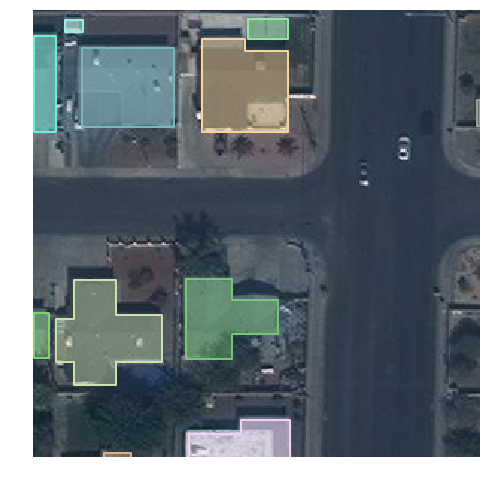

In [26]:
# load and render the image
plt.imshow(I); plt.axis('off')
# Render annotations on top of the image
coco.showAnns(annotations)

# Advanced

## 1.Convert `poly` segmentation to `rle`

In [27]:
ann_segmentation = annotations[0]['segmentation']

from pycocotools import mask as cocomask
rle = cocomask.frPyObjects(ann_segmentation, img['height'], img['width'])
print(rle)


[{'size': [300, 300], 'counts': b'i\\9e1g70000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000_Zl1'}]


## 2. Convert segmentation to pixel level masks

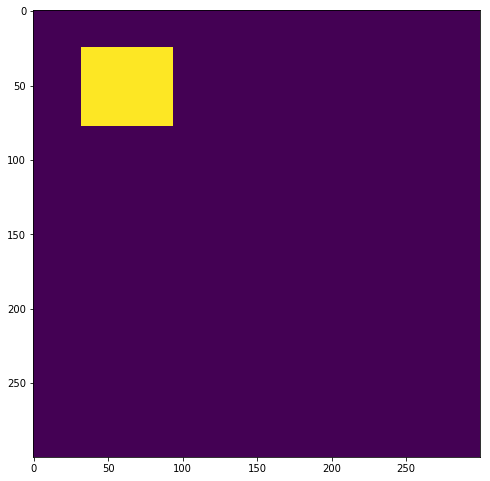

In [29]:
from pycocotools import mask as cocomask
rle = cocomask.frPyObjects(annotations[0]['segmentation'], img['height'], img['width'])
m = cocomask.decode(rle)
# m.shape has a shape of (300, 300, 1)
# so we first convert it to a shape of (300, 300)
m = m.reshape((img['height'], img['width']))
plt.imshow(m)

but this shows just one of the buildings, and that is precisely right, as the `segmentation` key, stores a separate "mask" for every building. So you can plot all of them by : 

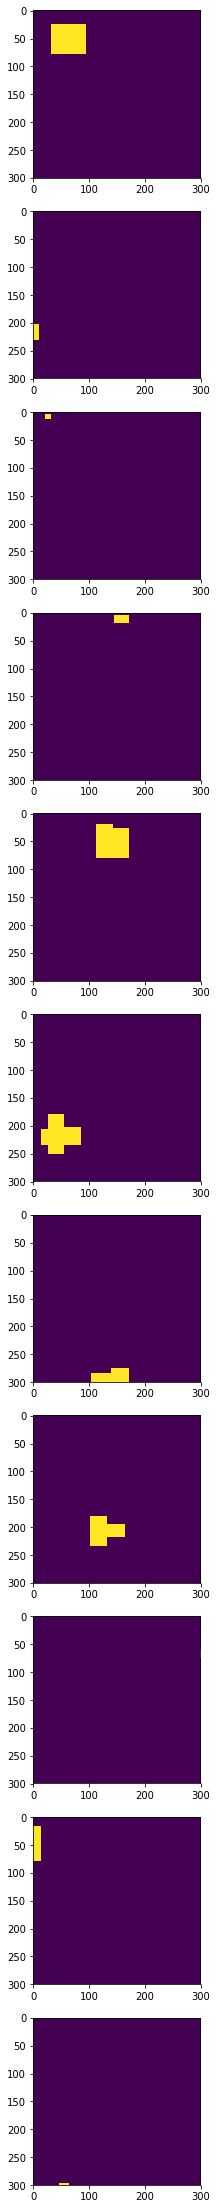

In [35]:
pylab.rcParams['figure.figsize'] = (10, 40.0)
for _idx, annotation in enumerate(annotations):
    plt.subplot(len(annotations), 1, _idx+1)
    rle = cocomask.frPyObjects(annotation['segmentation'], img['height'], img['width'])
    m = cocomask.decode(rle)
    # m.shape has a shape of (300, 300, 1)
    # so we first convert it to a shape of (300, 300)
    m = m.reshape((img['height'], img['width']))
    plt.imshow(m)